#**Analisis dan Prediksi Perilaku Pembelian Pengguna E-Commerce Menggunakan PySpark dan Machine Learning Berbasis Big Data**

#**Dikerjakan oleh:**
##**Ridho Akbar - 23.11.5717**
##**Raid Althaf Wilian - 23.11.5725**

#**Latar Belakang**
Pertumbuhan platform e-commerce menghasilkan data aktivitas pengguna dalam jumlah yang sangat besar (Big Data), seperti aktivitas melihat produk (view), menambahkan ke keranjang (cart), dan melakukan pembelian (purchase). Data ini menyimpan informasi berharga untuk memahami perilaku pengguna dan meningkatkan strategi bisnis, seperti personalisasi promosi dan rekomendasi produk.

Namun, volume data yang besar membutuhkan pendekatan komputasi terdistribusi serta algoritma Machine Learning yang efisien. Oleh karena itu, penelitian ini memanfaatkan PySpark sebagai framework Big Data dan membandingkan algoritma Logistic Regression dan Random Forest untuk memprediksi apakah pengguna yang menambahkan produk ke keranjang akan melakukan pembelian.

#**Tujuan**
Membersihkan dan mempersiapkan data e-commerce dalam skala besar menggunakan PySpark

Melakukan Exploratory Data Analysis (EDA) terhadap perilaku pengguna

Membangun model klasifikasi untuk memprediksi kemungkinan pembelian

Membandingkan performa Logistic Regression dan Random Forest

Mengevaluasi model menggunakan F1-Score sebagai metrik utama

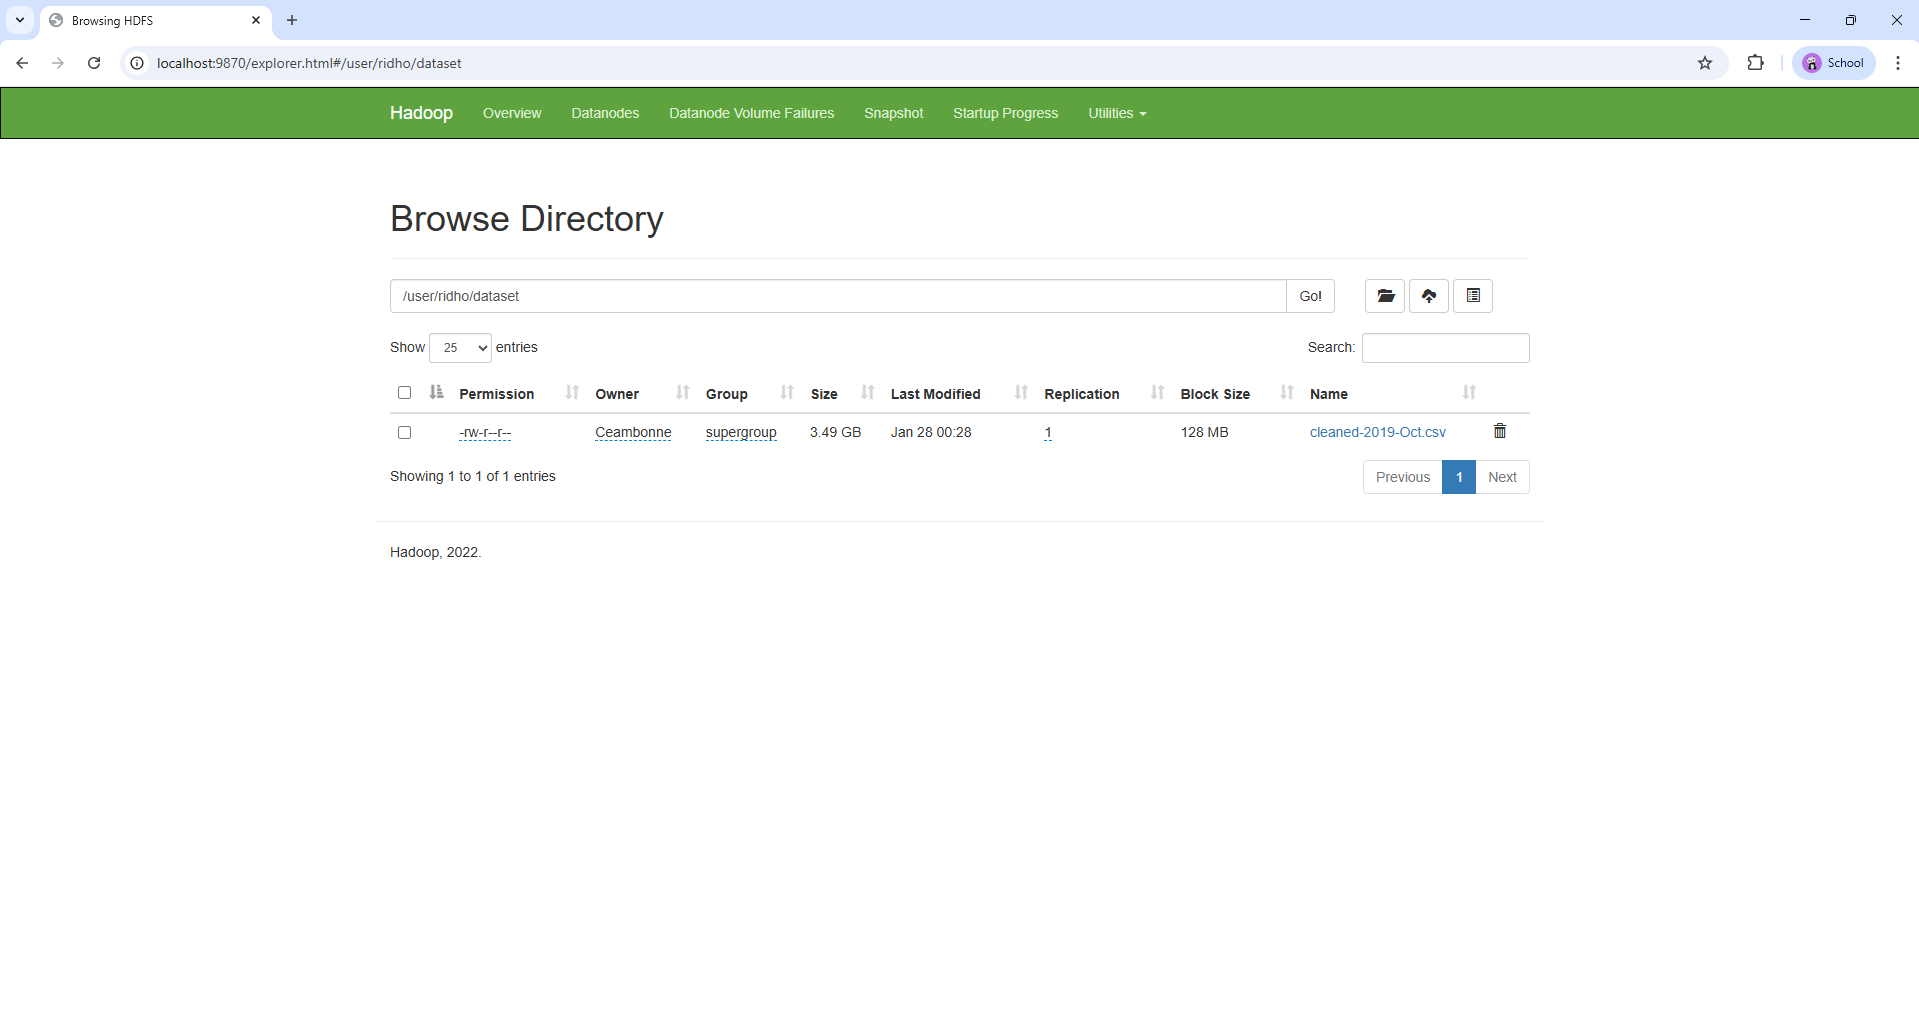

##Link Github : https://github.com/ridho-beep/Big_Data_Predictive_Analysis_Lanjut
##Link LaunchinPad : https://launchinpad.amikom.ac.id/project/analisis-prediksi-dataset-e-commerce-b922695
##Link Dataset : https://www.kaggle.com/datasets/andydovn/ecommerce-behavior-data-from-multi-category-store/data

#**Setup & Mount Drive**

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Ecommerce Big Data") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Dataset**

In [48]:
csv_path = "/content/drive/MyDrive/Semester 5/Big Data Analystic/FP/cleaned-2019-Oct.csv"
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv(csv_path)

df.printSchema()
df.describe().show()
df.groupBy("event_type").count().show()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)

+-------+----------+-----------------+--------------------+-------------------+--------+------------------+-------------------+--------------------+
|summary|event_type|       product_id|         category_id|      category_code|   brand|             price|            user_id|        user_session|
+-------+----------+-----------------+--------------------+-------------------+--------+------------------+-------------------+--------------------+
|  count|  26560622|         26560622|            26560622|           26560622|26560622|          26560622|           26560622|            26560620|
|   mean|      NULL|5366

#**Cleaning Data**

In [53]:
from pyspark.sql.functions import col, when
df_true = df.select(
    "event_type",
    "product_id",
    "category_id",
    "price",
    "user_id"
)

# Hapus missing value
df_true = df.dropna()

# Validasi harga
df_true = df.filter(col("price") > 0)

# Casting tipe data
df_true = df.withColumn("price", col("price").cast("double")) \
       .withColumn("product_id", col("product_id").cast("long")) \
       .withColumn("category_id", col("category_id").cast("long")) \
       .withColumn("user_id", col("user_id").cast("long"))

Memilih kolom penting yang relevan dengan perilaku pengguna dan transaksi, menghapus baris yang memiliki nilai kosong (missing value) untuk menjaga kualitas data, menghapus data dengan harga tidak valid, dan melakukan casting tipe data agar sesuai dengan kebutuhan Machine Learning.

#**Sampling Data**

In [60]:
df_sample = df_true.sample(
    fraction=0.05,
    seed=42
)

df_sample = df_sample.cache()
df_sample.count()

1327391

Melakukan sampling data 5% agar dapat mempercepat komputasi

#**Exploratory Data Analysis**

In [61]:
df_sample.groupBy("event_type").count().show()
df_sample.describe(["price"]).show()

+----------+-------+
|event_type|  count|
+----------+-------+
|      cart|  40374|
|  purchase|  27646|
|      view|1259371|
+----------+-------+

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|           1327391|
|   mean|352.74818039297173|
| stddev|381.43273943376624|
|    min|              0.88|
|    max|           2574.07|
+-------+------------------+



In [62]:
event_count = df_sample.rdd.map(lambda x: (x.event_type, 1)) \
                    .reduceByKey(lambda a, b: a + b)

event_count.collect()

[('purchase', 27646), ('view', 1259371), ('cart', 40374)]

Exploratory Data Analysis (EDA) dilakukan untuk memahami karakteristik awal data sebelum masuk ke tahap pemodelan. Pada tahap ini, dilakukan analisis distribusi jenis aktivitas pengguna (event_type) untuk mengetahui proporsi interaksi pengguna, seperti melihat produk, menambahkan ke keranjang, dan melakukan pembelian.

Selanjutnya, dilakukan analisis statistik deskriptif pada variabel price untuk mengidentifikasi rentang harga, nilai rata-rata, serta variasi harga produk. Analisis ini bertujuan untuk memahami pola harga yang dapat memengaruhi keputusan pembelian.

Selain itu, digunakan pendekatan MapReduce berbasis RDD untuk menghitung jumlah setiap jenis aktivitas sebagai bentuk pemrosesan batch dalam Big Data. Hasil EDA digunakan sebagai dasar dalam menentukan strategi pelabelan data dan pemilihan algoritma machine learning pada tahap selanjutnya.

#**Labeling**

In [63]:
# Ambil data cart
df_cart = df_sample.filter(col("event_type") == "cart")

# Ambil data purchase (label = 1)
df_purchase = df_sample.filter(col("event_type") == "purchase") \
    .select("user_id", "product_id") \
    .withColumn("label", when(col("product_id").isNotNull(), 1))

# Join cart dengan purchase
df_labeled = df_cart.join(
    df_purchase,
    ["user_id", "product_id"],
    "left"
).fillna({"label": 0})

In [64]:
df_labeled.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|37693|
|    1| 3295|
+-----+-----+



Pada tahap ini, dilakukan pelabelan data untuk membentuk dataset supervised learning. Data difokuskan pada aktivitas pengguna yang menambahkan produk ke keranjang (cart), karena aktivitas ini merepresentasikan niat awal pengguna untuk melakukan pembelian.

Label kelas ditentukan berdasarkan keberadaan aktivitas pembelian (purchase) untuk kombinasi user_id dan product_id yang sama. Jika pengguna yang telah memasukkan produk ke keranjang kemudian melakukan pembelian, maka data diberi label 1 (pembelian). Sebaliknya, jika tidak terdapat aktivitas pembelian setelah produk dimasukkan ke keranjang, maka data diberi label 0 (tidak membeli).

Hasil dari tahap ini adalah dataset dengan dua kelas yang jelas, yang digunakan sebagai target pada proses pemodelan machine learning untuk memprediksi kemungkinan pembelian pengguna.

#**Feature Enginering**

In [65]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=["price", "product_id", "category_id"],
    outputCol="features"
)

df_final = assembler.transform(df_labeled) \
    .select("features", "label")

Pada tahap feature engineering, dilakukan pembentukan fitur numerik yang akan digunakan sebagai input pada model machine learning. Fitur yang digunakan terdiri dari price, product_id, dan category_id, yang merepresentasikan nilai transaksi serta karakteristik produk dan kategorinya.

Seluruh fitur numerik tersebut kemudian digabungkan ke dalam satu vektor fitur menggunakan metode Vector Assembler. Proses ini menghasilkan satu kolom fitur terstruktur yang dapat diproses oleh algoritma machine learning berbasis PySpark.

Hasil dari tahap ini adalah dataset akhir yang terdiri dari kolom features sebagai variabel independen dan label sebagai variabel target, sehingga data siap digunakan pada tahap pelatihan dan pengujian model klasifikasi.

#**Split Data + Modeling**

In [66]:
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

In [68]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_df)
lr_pred = lr_model.transform(test_df)


rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=20,
    maxDepth=5,
    seed=42
)
rf_model = rf.fit(train_df)
rf_pred = rf_model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(metricName="f1")
lr_f1 = evaluator.evaluate(lr_pred)
rf_f1 = evaluator.evaluate(rf_pred)

print("PERBANDINGAN MODEL:")
print(f"Logistic Regression F1 Score: {lr_f1:.2%}")
print(f"Random Forest F1 Score: {rf_f1:.2%}")


PERBANDINGAN MODEL:
Logistic Regression F1 Score: 88.42%
Random Forest F1 Score: 88.42%


In [69]:
best_model = "Logistic Regression" if lr_f1 > rf_f1 else "Random Forest"
print("\nBest Model Based on F1-Score:", best_model)


Best Model Based on F1-Score: Random Forest


Berdasarkan hasil evaluasi menggunakan metrik F1-Score, diperoleh nilai yang sama antara model Logistic Regression dan Random Forest, yaitu sebesar 88.42%. Nilai ini menunjukkan bahwa kedua model memiliki kemampuan yang seimbang dalam mengklasifikasikan pengguna yang melakukan pembelian maupun yang tidak melakukan pembelian.

Meskipun nilai F1-Score kedua model identik, Random Forest dipilih sebagai model terbaik. Pemilihan ini didasarkan pada karakteristik Random Forest yang lebih mampu menangkap hubungan non-linear dan interaksi kompleks antar fitur dibandingkan Logistic Regression. Hal tersebut menjadikan Random Forest lebih robust terhadap variasi data dan lebih adaptif terhadap pola perilaku pengguna yang kompleks.

Dengan demikian, Random Forest dianggap lebih sesuai untuk digunakan pada tahap lanjutan, seperti hyperparameter tuning dan analisis lebih mendalam, meskipun performa awalnya setara dengan Logistic Regression.

#**Hyperparameter Tuning**

In [70]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [10, 20])
    .addGrid(rf.maxDepth, [3, 5])
    .build()
)

cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cv_model = cv.fit(train_df)
cv_pred = cv_model.transform(test_df)
cv_f1 = evaluator.evaluate(cv_pred)

print(f"Best-Model (After Tuning): {cv_f1:.2%}")


Best-Model (After Tuning): 89.05%


Setelah dilakukan proses hyperparameter tuning pada model terbaik, diperoleh peningkatan kinerja dengan nilai F1-Score sebesar 89.05%. Hasil ini menunjukkan bahwa penyesuaian parameter model berhasil meningkatkan kemampuan klasifikasi dibandingkan dengan performa sebelum tuning.

Peningkatan nilai F1-Score mengindikasikan bahwa model memiliki keseimbangan yang lebih baik antara precision dan recall, sehingga lebih akurat dalam memprediksi pengguna yang akan melakukan pembelian maupun yang tidak. Hal ini menandakan bahwa model mampu mengenali pola perilaku pengguna secara lebih optimal setelah parameter-parameter penting disesuaikan.

Dengan hasil tersebut, model Random Forest hasil tuning dapat dianggap lebih optimal dan layak digunakan sebagai model akhir untuk memprediksi perilaku pembelian pengguna pada platform e-commerce berbasis Big Data.

#**Evaluasi + Confusion Matriks**

In [72]:
acc = evaluator.evaluate(cv_pred, {evaluator.metricName: "accuracy"})
prec = evaluator.evaluate(cv_pred, {evaluator.metricName: "weightedPrecision"})
rec = evaluator.evaluate(cv_pred, {evaluator.metricName: "weightedRecall"})

print("Evaluasi Matriks:")
print(f"Accuracy: {acc:.2%}")
print(f"Precision: {prec:.2%}")
print(f"Recall: {rec:.2%}")
print(f"F1 Score: {cv_f1:.2%}")

Evaluasi Matriks:
Accuracy: 92.31%
Precision: 90.22%
Recall: 92.31%
F1 Score: 89.05%


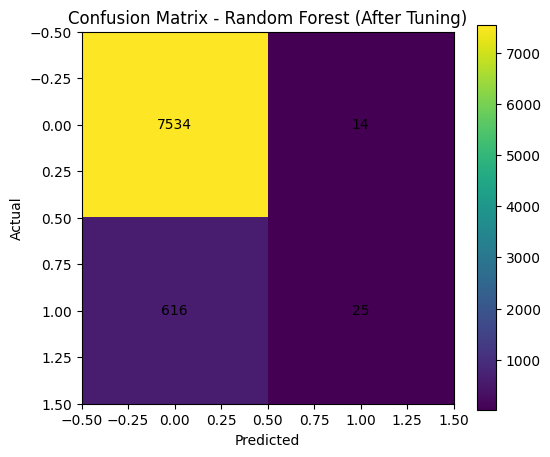

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Convert ke pandas
y_true = cv_pred.select("label").toPandas()
y_pred = cv_pred.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix - Random Forest (After Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()

Berdasarkan confusion matrix, dapat disimpulkan bahwa model Random Forest hasil hyperparameter tuning memiliki performa yang stabil dan andal dalam memprediksi perilaku pembelian pengguna. Model sangat efektif dalam mengidentifikasi pengguna yang tidak akan membeli serta memiliki tingkat kesalahan prediksi yang rendah.

Meskipun masih terdapat keterbatasan dalam menangkap seluruh pengguna yang benar-benar melakukan pembelian, secara keseluruhan model sudah cukup baik dan layak digunakan sebagai dasar pengambilan keputusan bisnis, seperti strategi promosi, rekomendasi produk, dan analisis perilaku pelanggan pada platform e-commerce berbasis Big Data.